### Get the materials

In [13]:
# Requires the latest pip
# !pip3 install --user --upgrade pip

# Current stable release for CPU and GPU
# !pip3 install --user tensorflow
# !pip3 install --user keras

# conda install -c conda-forge keras tensorflow
# conda update -n base -c defaults conda

In [5]:
# unzip file with all images and labels
# filename = 'cifar-10-python.tar.gz'
# tar = tarfile.open(filename, 'r:gz')
# tar.extractall()
# tar.close()

In [3]:
projectpath = r'C:\Users\Sophie\sophie-robert\final-project'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
import pickle

In [6]:
# define a function to unpack the data into a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding = 'bytes')
    return dict

In [118]:
# one hot encode the labels (could have just used keras.utils to_categorical)
def one_hot_encode(train_labels):
    encoded = np.zeros((n_imgs, len(np.unique(train_labels))))
    for idx,lbl in enumerate(train_labels,0):
        encoded[idx][lbl] = 1
    return encoded

In [132]:
# data comes in vectors so reshape then normalize
def reshape_data(batchdata):
    n_channels = 3
    n_imgs     = batchdata.shape[0]
    img_dim    = int(np.sqrt(batchdata.shape[1]/n_channels))
    train_data = batchdata.reshape((n_imgs, n_channels, img_dim, img_dim)).transpose(0, 2, 3, 1)
    train_data = (train_data / 255) - 0.5
    return train_data, img_dim

In [278]:
# unpack the data from the batches, do a bunch of stuff, then combine them
batchpath  = os.path.join(projectpath, 'cifar-10-batches-py')

for set in range(1,6):
    if set == 1:
        dirname      = os.path.join(batchpath, 'data_batch_' + str(set))
        batch        = unpickle(dirname)
        train_data   = reshape_data(batch[b'data'])        
        train_labels = one_hot_encode(batch[b'labels'])
    else:
        dirname       = os.path.join(batchpath, 'data_batch_' + str(set))
        batch         = unpickle(dirname)
        train_data2   = reshape_data(batch[b'data'])
        train_labels2 = one_hot_encode(batch[b'labels'])
        train_data    = np.concatenate((train_data, train_data2))
        train_labels  = np.concatenate((train_labels, train_labels2))

In [289]:
# unpack the data from the batches, do a bunch of stuff, then combine them
batchpath   = os.path.join(projectpath, 'cifar-10-batches-py')
dirname     = os.path.join(batchpath, 'test_batch')
testbatch   = unpickle(dirname)
test_data   = reshape_data(testbatch[b'data'])        
test_labels = one_hot_encode(testbatch[b'labels'])

In [290]:
test_labels.shape

(10000, 10)

### Figure out what is in the batch

In [114]:
# what are the key types
list(batch.keys())

[b'batch_label', b'labels', b'data', b'filenames']

In [121]:
len(batch[b'labels'])

10000

In [103]:
# rows = images, columns = pixels in an image
batch[b'data'].shape 

(10000, 3072)

In [229]:
# back calculating the shape of the image
n_channels = 3
n_imgs = batch[b'data'].shape[0]
img_dim = int(np.sqrt(batch[b'data'].shape[1]/n_channels))

train_data = batch[b'data'].reshape((n_imgs, n_channels, img_dim, img_dim)).transpose(0, 2, 3, 1)

In [274]:
# normalize the images
train_data = (train_data / 255) - 0.5

### Build the network

In [296]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size = 3, 
                 activation  = 'relu', 
                 padding     = 'same', 
                 input_shape = (img_dim,
                                img_dim,
                                3)))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))
model.add(Conv2D(32,
                 kernel_size = 5, 
                 activation  = 'relu',
                 padding     = 'same'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))
model.add(Conv2D(64,
                 kernel_size = 3, 
                 activation  = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 
                 kernel_size = 3, 
                 activation  = 'relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense  (64,  activation='relu'))
model.add(Dense  (128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense  (64,  activation='relu'))
model.add(Dense  (10,  activation='softmax'))

early_stopping_monitor = EarlyStopping(patience = 15,
                                       restore_best_weights = True)

model.compile(optimizer = 'adam', 
              loss      = 'categorical_crossentropy', 
              metrics   = ['accuracy'])

training = model.fit(train_data, 
                     train_labels, 
                     validation_split = 0.2, 
                     epochs = 100, 
                     batch_size = 125,
                     callbacks = [early_stopping_monitor])

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 84s 2ms/step - loss: 1.6033 - accuracy: 0.4168 - val_loss: 1.9924 - val_accuracy: 0.2332
Epoch 2/100
40000/40000 [==============================] - 81s 2ms/step - loss: 1.2026 - accuracy: 0.5648 - val_loss: 1.2889 - val_accuracy: 0.5311
Epoch 3/100
40000/40000 [==============================] - 81s 2ms/step - loss: 1.0522 - accuracy: 0.6246 - val_loss: 1.0380 - val_accuracy: 0.6287
Epoch 4/100
40000/40000 [==============================] - 82s 2ms/step - loss: 0.9589 - accuracy: 0.6592 - val_loss: 0.9362 - val_accuracy: 0.6673
Epoch 5/100
40000/40000 [==============================] - 82s 2ms/step - loss: 0.8852 - accuracy: 0.6836 - val_loss: 0.9301 - val_accuracy: 0.6747
Epoch 6/100
40000/40000 [==============================] - 81s 2ms/step - loss: 0.8363 - accuracy: 0.7013 - val_loss: 0.8613 - val_accuracy: 0.6974
Epoch 7/100
40000/40000 [==============================] - 81s

In [301]:
model.save('model_saved7.h5')

In [144]:
conv1 = model.layers[0]
weights1 = conv1.get_weights()
kernels1 = weights1[0]
kernels1.shape

(3, 3, 3, 16)

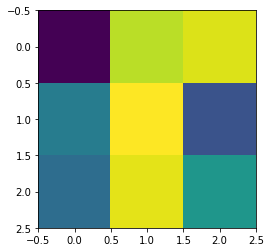

In [172]:
kernels1_1 = kernels1[:,:,:,0]
kernels1_1
kernels1_1avg = np.mean(kernels1_1, axis=0)

plt.imshow(kernels1_1avg);
plt.axis('off')

In [195]:
def convolution(kernel, image):
    img_dim     = image.shape[0]
    channels    = image.shape[2]
    kernel_size = kernel.shape[0]
    output_size = img_dim-(kernel_size-1)
    conv        = np.zeros((output_size,output_size))
    
    for ii in range(output_size):
        for jj in range(output_size):
            window = image[ii:ii+kernel_size, jj:jj+kernel_size]
            conv[ii,jj] = np.sum(window*kernel)
            
    return conv

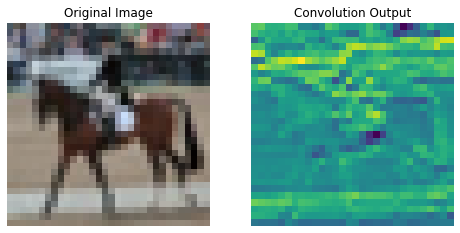

In [273]:
image = train_data[25,:,:,:]
conv = convolution(kernels1_1, image)

fig, axs = plt.subplots(1, 2, figsize=(8, 8))
axs[0].set_title('Original Image')
axs[0].imshow(image);
axs[0].axis('off')

axs[1].set_title('Convolution Output')
axs[1].imshow(conv);
axs[1].axis('off')
plt.show()

In [295]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 16, 32)        25632     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 6, 6, 64)        

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 15)

score = model.evaluate(test_data, 
                       test_labels,
                       callbacks = [early_stopping_monitor], 
                       batch_size = 125)

print('Test loss:', score[0])
print('Test accuracy:', score[1])